# Agentic Patterns: ReAct, Plan-Execute, and Reflection

**Learning Objectives:**
- Understand core agentic design patterns
- Build ReAct pattern from scratch
- Use helper functions for quick agent creation
- Implement Plan-Execute and Reflection patterns
- Know when to use manual graphs vs helpers

**Prerequisites:** Notebooks 01, 02, 03 (LangGraph Basics, Tools, Agentic RAG)


---

## Section 1: Introduction to Agentic Patterns

In notebooks 01-03, you built agents from scratch using StateGraph. But there are **common patterns** that appear repeatedly in agent design.

### What Are Agentic Patterns?

Agentic patterns are reusable blueprints for building agents.
**Instead of asking:** “How do I design this agent from scratch?”
**You ask:** “Which pattern fits this problem best?”

Think of patterns like design templates for reasoning + tool usage.


### The Three Core Agentic Patterns

**ReAct** (Reason + Act)
- Think → Act → Observe → Repeat
- Most common pattern for tool-using agents
- What you've been building in previous notebooks

**Plan-Execute**
- Plan all steps upfront → Execute each step
- Better for complex multi-step tasks
- Can replan if execution fails

**Reflection**
- Generate → Self-critique → Refine → Return
- Best for quality-critical outputs
- Similar to Self-RAG but more general


### Why Learn Patterns?

1. **Faster development** - Don't reinvent the wheel
2. **Better designs** - Learn from proven approaches
3. **Common language** - Communicate with other developers
4. **Production ready** - Used in real systems

**Today you'll master all three patterns!**

---
## Section 2: Setup

In [1]:
# Install required packages
!pip install -q langgraph langchain langchain-openai python-dotenv

In [2]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated
import operator
import os

print("✅ All imports successful")

✅ All imports successful


In [3]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("✅ API key loaded")

✅ API key loaded


In [4]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


---
## Section 3: ReAct Pattern - The Foundation

### What is ReAct?

**ReAct = Reasoning + Acting**

The agent alternates between thinking and acting:

```
User Query
   ↓
1. REASON: "I need to calculate this"
   ↓
2. ACT: Call calculator tool
   ↓
3. OBSERVE: Look at the tool result
   ↓
4. REASON: "Now I have the answer"
   ↓
5. RESPOND: Return final answer
```

This is what you've been building in Notebooks 02-03!

### Create Sample Tools

In [5]:
@tool
def calculator(expression: str) -> str:
    """
    Calculate mathematical expressions.
    
    Args:
        expression: Math expression like "2 + 2" or "15 * 37"
    """
    try:
        result = eval(expression, {"__builtins__": {}}, {})
        return str(result)
    except Exception as e:
        return f"Error: {str(e)}"

@tool
def search(query: str) -> str:
    """
    Search for information (simulated).
    
    Args:
        query: The search query
    """
    # Simulated search results
    knowledge = {
        "python": "Python is a high-level programming language created in 1991.",
        "langgraph": "LangGraph is a framework for building stateful multi-actor applications.",
        "react": "ReAct is an agent pattern that combines reasoning and acting."
    }
    
    for key, value in knowledge.items():
        if key in query.lower():
            return value
    
    return "No information found."

tools = [calculator, search]
print("✅ Tools created")

✅ Tools created


---
## Section 4: ReAct - Manual Implementation

First, let's build ReAct **from scratch** to understand how it works.

In [6]:
# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools)

# System prompt
react_prompt = SystemMessage(content="""You are a helpful assistant with tools.

Use calculator for math and search for information.
Think step-by-step before using tools.""")

# Define nodes
def react_assistant(state: MessagesState) -> dict:
    """Agent node - reasons and decides which tool to use."""
    messages = [react_prompt] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """Route to tools or end."""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

# Build graph
react_builder = StateGraph(MessagesState)
react_builder.add_node("assistant", react_assistant)
react_builder.add_node("tools", ToolNode(tools))

react_builder.add_edge(START, "assistant")
react_builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
react_builder.add_edge("tools", "assistant")  # Loop back for multi-step reasoning

react_agent_manual = react_builder.compile(checkpointer=MemorySaver())

print("✅ ReAct agent (manual) created")

✅ ReAct agent (manual) created


In [7]:
# Visualize
try:
    display(Image(react_agent_manual.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → assistant ↔ tools → END")

Could not display graph: Failed to reach https://mermaid.ink API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`
Graph: START → assistant ↔ tools → END


**🎨 Notice the cycle:** assistant ↔ tools allows multi-step reasoning!

### Test Manual ReAct

In [8]:
def test_agent(agent, query: str, agent_name: str = "Agent"):
    print(f"\n{'='*80}")
    print(f"👤 User: {query}")
    print(f"🤖 {agent_name} (FULL TRACE)")
    print(f"{'='*80}\n")

    result = agent.invoke(
        {"messages": [HumanMessage(content=query)]},
        config={"configurable": {"thread_id": f"test_{agent_name}"}}
    )

    for i, msg in enumerate(result["messages"]):
        print(f"\n--- Step {i+1} ---")

        if isinstance(msg, HumanMessage):
            print("👤 Human:")
            print(msg.content)

        elif isinstance(msg, AIMessage):
            print("🤖 Assistant:")
            print(msg.content)

            # 🔥 THIS IS IMPORTANT
            if msg.tool_calls:
                print("\n🛠 Tool Calls:")
                for tc in msg.tool_calls:
                    print(f"  • Tool name: {tc['name']}")
                    print(f"  • Arguments: {tc['args']}")

        elif isinstance(msg, ToolMessage):
            print("🧰 Tool Result:")
            print(f"Tool: {msg.name}")
            print(f"Output: {msg.content}")

    final_answer = result["messages"][-1].content

    print(f"\n{'='*80}")
    print("✅ FINAL ANSWER:")
    print(final_answer)
    print(f"{'='*80}\n")

    return final_answer

In [9]:
# Multi-step test
test_agent(
    react_agent_manual,
    "What is react ?",
    "Manual ReAct_0"
)


👤 User: What is react ?
🤖 Manual ReAct_0 (FULL TRACE)


--- Step 1 ---
👤 Human:
What is react ?

--- Step 2 ---
🤖 Assistant:


🛠 Tool Calls:
  • Tool name: search
  • Arguments: {'query': 'What is React?'}

--- Step 3 ---
🧰 Tool Result:
Tool: search
Output: ReAct is an agent pattern that combines reasoning and acting.

--- Step 4 ---
🤖 Assistant:
React is a popular JavaScript library used for building user interfaces, particularly for single-page applications where you need a fast and interactive user experience. It allows developers to create reusable UI components, manage the state of applications efficiently, and handle updates in a way that optimizes performance.

Key features of React include:

1. **Component-Based Architecture**: React applications are built using components, which are self-contained modules that can manage their own state and render UI.

2. **Virtual DOM**: React uses a virtual representation of the DOM to optimize rendering. When the state of an object changes

'React is a popular JavaScript library used for building user interfaces, particularly for single-page applications where you need a fast and interactive user experience. It allows developers to create reusable UI components, manage the state of applications efficiently, and handle updates in a way that optimizes performance.\n\nKey features of React include:\n\n1. **Component-Based Architecture**: React applications are built using components, which are self-contained modules that can manage their own state and render UI.\n\n2. **Virtual DOM**: React uses a virtual representation of the DOM to optimize rendering. When the state of an object changes, React updates only the parts of the DOM that have changed, rather than reloading the entire page.\n\n3. **Declarative Syntax**: React allows developers to describe what the UI should look like for a given state, making it easier to understand and debug.\n\n4. **Unidirectional Data Flow**: Data flows in one direction, from parent components

In [10]:
# Multi-step test
test_agent(
    react_agent_manual,
    "Search for information about Python, then calculate 2 ** 10",
    "Manual ReAct_2"
)


👤 User: Search for information about Python, then calculate 2 ** 10
🤖 Manual ReAct_2 (FULL TRACE)


--- Step 1 ---
👤 Human:
Search for information about Python, then calculate 2 ** 10

--- Step 2 ---
🤖 Assistant:


🛠 Tool Calls:
  • Tool name: search
  • Arguments: {'query': 'Python programming language'}
  • Tool name: calculator
  • Arguments: {'expression': '2 ** 10'}

--- Step 3 ---
🧰 Tool Result:
Tool: search
Output: Python is a high-level programming language created in 1991.

--- Step 4 ---
🧰 Tool Result:
Tool: calculator
Output: 1024

--- Step 5 ---
🤖 Assistant:
Python is a high-level programming language created in 1991. It is known for its readability and simplicity, making it a popular choice for beginners and experienced developers alike.

The calculation of \(2^{10}\) equals 1024.

✅ FINAL ANSWER:
Python is a high-level programming language created in 1991. It is known for its readability and simplicity, making it a popular choice for beginners and experienced developers 

'Python is a high-level programming language created in 1991. It is known for its readability and simplicity, making it a popular choice for beginners and experienced developers alike.\n\nThe calculation of \\(2^{10}\\) equals 1024.'

**🎯 Observe:** Agent uses MULTIPLE tools in sequence - this is ReAct!

In [11]:
# Multi-step test
test_agent(
    react_agent_manual,
    "What is LLM",
    "Manual ReAct_33"
)


👤 User: What is LLM
🤖 Manual ReAct_33 (FULL TRACE)


--- Step 1 ---
👤 Human:
What is LLM

--- Step 2 ---
🤖 Assistant:


🛠 Tool Calls:
  • Tool name: search
  • Arguments: {'query': 'What is LLM?'}

--- Step 3 ---
🧰 Tool Result:
Tool: search
Output: No information found.

--- Step 4 ---
🤖 Assistant:
LLM stands for "Large Language Model." It refers to a type of artificial intelligence model that is trained on vast amounts of text data to understand and generate human-like language. These models use deep learning techniques, particularly neural networks, to process and generate text based on the patterns they have learned from the training data.

Key characteristics of LLMs include:

1. **Scale**: They are typically very large, with billions or even trillions of parameters, which allows them to capture complex language patterns.

2. **Training**: LLMs are trained on diverse datasets that include books, articles, websites, and other text sources, enabling them to understand context, gramm

'LLM stands for "Large Language Model." It refers to a type of artificial intelligence model that is trained on vast amounts of text data to understand and generate human-like language. These models use deep learning techniques, particularly neural networks, to process and generate text based on the patterns they have learned from the training data.\n\nKey characteristics of LLMs include:\n\n1. **Scale**: They are typically very large, with billions or even trillions of parameters, which allows them to capture complex language patterns.\n\n2. **Training**: LLMs are trained on diverse datasets that include books, articles, websites, and other text sources, enabling them to understand context, grammar, and various topics.\n\n3. **Applications**: They can be used for a variety of tasks, including text generation, translation, summarization, question answering, and more.\n\n4. **Examples**: Some well-known LLMs include OpenAI\'s GPT (Generative Pre-trained Transformer) series, Google\'s BE

**🎯 Observe:** Seach couldn't find any information, the agent has to respond through the llm!

---
## Section 5: ReAct - Using Helper Functions

Now let's see the **shortcut** way using LangGraph's helper function.

### Why Helpers Exist

Building graphs manually is great for learning, but:
- **Repetitive** for common patterns
- **Time-consuming** for simple agents
- **Error-prone** if you forget edges

Helpers create the graph structure for you!

In [12]:
# Using create_react_agent helper
react_agent_helper = create_react_agent(
    model=llm,
    tools=tools,
    prompt=react_prompt
)

print("✅ ReAct agent (helper) created")
print("\n⚠️ Note: create_react_agent may show deprecation warning.")
print("   This is OK - it's being moved to langchain.agents but still works!")

✅ ReAct agent (helper) created

⚠️ Note: create_react_agent may show deprecation warning.
   This is OK - it's being moved to langchain.agents but still works!


C:\Users\USER\AppData\Local\Temp\ipykernel_22312\2827895599.py:2: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_agent_helper = create_react_agent(


**💡 That's it!** One function call replaces all our manual graph building.

### Test Helper ReAct

In [13]:
test_agent(react_agent_helper, "What is 123 * 456?", "Helper ReAct_0")


👤 User: What is 123 * 456?
🤖 Helper ReAct_0 (FULL TRACE)


--- Step 1 ---
👤 Human:
What is 123 * 456?

--- Step 2 ---
🤖 Assistant:


🛠 Tool Calls:
  • Tool name: calculator
  • Arguments: {'expression': '123 * 456'}

--- Step 3 ---
🧰 Tool Result:
Tool: calculator
Output: 56088

--- Step 4 ---
🤖 Assistant:
The result of \( 123 \times 456 \) is 56,088.

✅ FINAL ANSWER:
The result of \( 123 \times 456 \) is 56,088.



'The result of \\( 123 \\times 456 \\) is 56,088.'

In [14]:
from langchain.agents import create_agent

create_agent_helper = create_agent(
    model=llm,
    tools=tools,
    system_prompt=react_prompt
)

In [15]:
test_agent(create_agent_helper, "What is 123 * 456?", "Helper ReAct_1")


👤 User: What is 123 * 456?
🤖 Helper ReAct_1 (FULL TRACE)


--- Step 1 ---
👤 Human:
What is 123 * 456?

--- Step 2 ---
🤖 Assistant:


🛠 Tool Calls:
  • Tool name: calculator
  • Arguments: {'expression': '123 * 456'}

--- Step 3 ---
🧰 Tool Result:
Tool: calculator
Output: 56088

--- Step 4 ---
🤖 Assistant:
The result of \( 123 \times 456 \) is 56,088.

✅ FINAL ANSWER:
The result of \( 123 \times 456 \) is 56,088.



'The result of \\( 123 \\times 456 \\) is 56,088.'

In [16]:
# Same multi-step test
test_agent(
    react_agent_helper,
    "Search for information about LangGraph, then calculate 15 * 25",
    "Helper ReAct_0"
)


👤 User: Search for information about LangGraph, then calculate 15 * 25
🤖 Helper ReAct_0 (FULL TRACE)


--- Step 1 ---
👤 Human:
Search for information about LangGraph, then calculate 15 * 25

--- Step 2 ---
🤖 Assistant:


🛠 Tool Calls:
  • Tool name: search
  • Arguments: {'query': 'LangGraph'}
  • Tool name: calculator
  • Arguments: {'expression': '15 * 25'}

--- Step 3 ---
🧰 Tool Result:
Tool: search
Output: LangGraph is a framework for building stateful multi-actor applications.

--- Step 4 ---
🧰 Tool Result:
Tool: calculator
Output: 375

--- Step 5 ---
🤖 Assistant:
LangGraph is a framework designed for building stateful multi-actor applications. 

Additionally, the result of the calculation \( 15 \times 25 \) is 375.

✅ FINAL ANSWER:
LangGraph is a framework designed for building stateful multi-actor applications. 

Additionally, the result of the calculation \( 15 \times 25 \) is 375.



'LangGraph is a framework designed for building stateful multi-actor applications. \n\nAdditionally, the result of the calculation \\( 15 \\times 25 \\) is 375.'

**🎉 Same behavior!** The helper creates the same graph structure internally.

---
## Section 6: Manual vs Helper - When to Use Which?

### Code Comparison

**Manual (20+ lines):**
```python
llm_with_tools = llm.bind_tools(tools)
def assistant(state): ...
def should_continue(state): ...

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(...)
builder.add_edge("tools", "assistant")
agent = builder.compile()
```

**Helper (3 lines):**
```python
agent = create_react_agent(
    model=llm, tools=tools, prompt=prompt
)
```

### Feature Comparison

| Feature | Manual Building | Helper Function |
|---------|----------------|----------------|
| **Lines of code** | 20-30 | 3-5 |
| **Learning value** | ✅ High | ⚠️ Low (black box) |
| **Flexibility** | ✅ Full control | ❌ Limited |
| **Speed** | ⚠️ Slow to write | ✅ Very fast |
| **Custom patterns** | ✅ Any pattern | ❌ Only ReAct |
| **Debugging** | ✅ See everything | ⚠️ Hidden internals |
| **Production** | ✅ Both work equally well | ✅ Both work equally well |

### Decision Guide

**Use Manual Building When:**
- ✅ Learning LangGraph
- ✅ Need custom patterns (Plan-Execute, Self-RAG, CRAG)
- ✅ Need fine control over graph structure
- ✅ Building multi-agent systems
- ✅ Debugging complex behavior

**Use Helper Functions When:**
- ✅ Simple ReAct pattern is enough
- ✅ Rapid prototyping
- ✅ You understand how it works internally
- ✅ Standard tool-calling agent
- ✅ Production code (if ReAct fits your needs)

### Progression Strategy

**Beginner:** Build manually to learn  
↓  
**Intermediate:** Use helpers for simple cases, manual for complex  
↓  
**Advanced:** Choose based on requirements, not convenience  

---
## Section 7: Plan-Execute Pattern

### What is Plan-Execute?

Instead of thinking step-by-step, the agent **plans everything upfront**:

```
User: "Research Python and write a summary"

PLANNER:
  Step 1: Search for Python information
  Step 2: Read and understand content
  Step 3: Write summary
  Step 4: Review and polish

EXECUTOR:
  Execute Step 1 ✓
  Execute Step 2 ✓
  Execute Step 3 ✓
  Execute Step 4 ✓

DONE!
```

### Benefits

- Better for complex multi-step tasks
- More predictable (plan visible upfront)
- User sees progress

### When to Use

- ✅ Complex tasks with clear steps
- ✅ Long-running workflows
- ✅ Need to show user the plan
- ❌ Simple queries (overkill)
- ❌ Highly dynamic tasks (hard to plan)

### Implementation

In [17]:
# Custom state for Plan-Execute
class PlanExecuteState(TypedDict):
    """State for plan-execute pattern."""
    input: str  # Original user query
    plan: list[str]  # List of steps
    current_step: int  # Which step we're on
    results: Annotated[list[str], operator.add]  # Results from each step
    final_output: str  # Final answer

print("✅ Plan-Execute state defined")

✅ Plan-Execute state defined


In [18]:
# Node 1: Planner
def planner(state: PlanExecuteState) -> dict:
    """Create a step-by-step plan."""
    prompt = f"""Create a step-by-step plan for this task:

Task: {state['input']}

Return a numbered list of concrete steps. Keep it simple (3-5 steps)."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    
    # Parse steps (simple parsing)
    lines = response.content.split('\n')
    steps = [line.strip() for line in lines if line.strip() and any(char.isdigit() for char in line[:3])]
    
    print(f"\n📋 PLAN CREATED:")
    for step in steps:
        print(f"  {step}")
    print()
    
    return {"plan": steps, "current_step": 0, "results": []}

# Node 2: Executor
def executor(state: PlanExecuteState) -> dict:
    """Execute current step."""
    if state["current_step"] >= len(state["plan"]):
        # All steps done
        return {}
    
    current_step = state["plan"][state["current_step"]]
    
    print(f"⚙️ Executing: {current_step}")
    
    # Execute step (simplified - just use LLM)
    prompt = f"""Previous results: {state.get('results', [])}\n\nExecute this step: {current_step}"""
    response = llm.invoke([HumanMessage(content=prompt)])
    
    result = f"Step {state['current_step'] + 1} result: {response.content}"
    print(result)
    print(f"✓ Done\n")
    
    return {
        "results": [result],
        "current_step": state["current_step"] + 1
    }

# Node 3: Finalizer
def finalizer(state: PlanExecuteState) -> dict:
    """Create final output from all results."""
    prompt = f"""Combine these step results into a final answer:

Original task: {state['input']}

Results: {state['results']}

Provide a clear, concise final answer."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"final_output": response.content}

print("✅ Plan-Execute nodes defined")

✅ Plan-Execute nodes defined


In [19]:
# Routing function
def should_continue_execution(state: PlanExecuteState) -> Literal["executor", "finalizer"]:
    """Decide if more steps to execute."""
    if state["current_step"] < len(state["plan"]):
        return "executor"
    return "finalizer"

# Build Plan-Execute graph
plan_execute_builder = StateGraph(PlanExecuteState)

plan_execute_builder.add_node("planner", planner)
plan_execute_builder.add_node("executor", executor)
plan_execute_builder.add_node("finalizer", finalizer)

plan_execute_builder.add_edge(START, "planner")
plan_execute_builder.add_edge("planner", "executor")
plan_execute_builder.add_conditional_edges(
    "executor",
    should_continue_execution,
    {"executor": "executor", "finalizer": "finalizer"}  # Can loop back to executor
)
plan_execute_builder.add_edge("finalizer", END)

plan_execute_agent = plan_execute_builder.compile()

print("✅ Plan-Execute agent created")

✅ Plan-Execute agent created


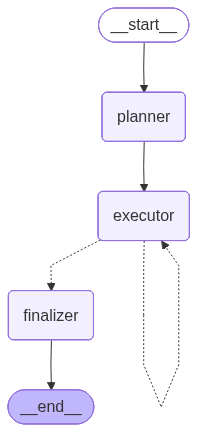

In [28]:
# Visualize
try:
    display(Image(plan_execute_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → planner → executor (loops) → finalizer → END")

**🎨 Notice:** executor can loop back to itself until all steps done!

### Test Plan-Execute

In [21]:
result = plan_execute_agent.invoke({
    "input": "Research what ReAct pattern is and explain it simply"
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT:")
print(f"{'='*70}")
print(result["final_output"])
print(f"{'='*70}\n")


📋 PLAN CREATED:
  1. **Define the ReAct Pattern**: Start by looking up the basic definition of the ReAct pattern in the context of programming or software development. Identify its purpose and key components.
  2. **Gather Resources**: Find reliable sources such as articles, tutorials, or videos that explain the ReAct pattern. Look for examples that illustrate how it is used in real-world applications.
  3. **Summarize Key Points**: Take notes on the most important aspects of the ReAct pattern, including its benefits, use cases, and any relevant examples. Aim to distill the information into simple terms.
  4. **Create a Simple Explanation**: Write a brief explanation of the ReAct pattern using the notes you gathered. Focus on clarity and simplicity, avoiding technical jargon where possible.
  5. **Review and Revise**: Read through your explanation to ensure it is easy to understand. Make any necessary adjustments to improve clarity and conciseness before finalizing your explanation.



In [22]:
result = plan_execute_agent.invoke({
    "input": "Research what ReAct pattern is and explain it simply"
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT:")
print(f"{'='*70}")
print(result["final_output"])
print(f"{'='*70}\n")


📋 PLAN CREATED:
  1. **Define the ReAct Pattern**: Start by looking up the basic definition of the ReAct pattern in the context of programming or software development. Identify its purpose and key components.
  2. **Gather Resources**: Find reliable sources such as articles, tutorials, or videos that explain the ReAct pattern. Look for examples that illustrate how it is used in real-world applications.
  3. **Summarize Key Points**: Take notes on the most important aspects of the ReAct pattern, including its benefits, use cases, and any common challenges associated with it.
  4. **Create a Simple Explanation**: Write a clear and concise explanation of the ReAct pattern in your own words, using simple language that can be easily understood by someone unfamiliar with the topic.
  5. **Review and Refine**: Go over your explanation to ensure clarity and accuracy. Make any necessary adjustments to improve understanding and flow.

⚙️ Executing: 1. **Define the ReAct Pattern**: Start by look

**🎯 Observe:** You can see the plan and watch each step execute!

## Differences between ReAct and Execute
| Aspect | ReAct | Plan-Execute |
|--------|-------|--------------|
| Decision-making | Agent decides at each step | Plan decided upfront |
| Adaptability | High — can change strategy | Low — follows plan |
| Workflow | Dynamic loop | Structured sequence |
| Agent role | Active decision-maker | Executor of plan |
| When to stop | Agent decides | When plan is done |

---
## Section 8: Reflection Pattern

### What is Reflection?

The agent **critiques its own work** and improves it:

```
1. GENERATE: Create initial answer
2. REFLECT: Evaluate quality (what's wrong?)
3. REFINE: Improve based on critique
4. REPEAT: Until quality threshold met (or max iterations)
```

### Benefits

- Higher quality outputs
- Self-correcting
- Works for any generation task

### When to Use

- ✅ Quality-critical tasks (writing, code)
- ✅ Creative tasks that benefit from iteration
- ✅ When you can define quality criteria
- ❌ Simple Q&A (overkill)
- ❌ Cost-sensitive (uses more tokens)

### Implementation

In [23]:
# Custom state for Reflection
class ReflectionState(TypedDict):
    """State for reflection pattern."""
    task: str  # Original task
    draft: str  # Current draft
    critique: str  # Critique of draft
    iterations: int  # Number of refinements
    final_output: str  # Final result

MAX_REFLECTIONS = 2  # Prevent infinite loops

print("✅ Reflection state defined")

✅ Reflection state defined


In [24]:
# Node 1: Generator
def generator(state: ReflectionState) -> dict:
    """Generate or refine based on critique."""
    if state["iterations"] == 0:
        # First generation
        prompt = f"""Create a response for this task:

Task: {state['task']}

Provide a clear, complete answer."""
        print("\n✍️ Generating initial draft...")
    else:
        # Refinement based on critique
        prompt = f"""Improve this draft based on the critique:

Task: {state['task']}

Current draft: {state['draft']}

Critique: {state['critique']}

Create an improved version."""
        print(f"\n✍️ Refining (iteration {state['iterations']})...")
    
    response = llm.invoke([HumanMessage(content=prompt)])
    print("✓ Draft created\n")
    
    return {"draft": response.content}

# Node 2: Critic
def critic(state: ReflectionState) -> dict:
    """Evaluate draft and provide critique."""
    prompt = f"""Evaluate this response and provide constructive critique:

Task: {state['task']}

Response: {state['draft']}

Critique the response. What could be improved?
If it's excellent, say "APPROVED: explanation".
Otherwise, provide specific improvements needed."""
    
    print("🔍 Critiquing draft...")
    response = llm.invoke([HumanMessage(content=prompt)])
    critique = response.content
    
    print(f"Critique: {critique[:100]}\n")
    
    return {
        "critique": critique,
        "iterations": state["iterations"] + 1
    }

# Node 3: Finalizer
def reflection_finalizer(state: ReflectionState) -> dict:
    """Set final output."""
    print("\n✅ Reflection complete!\n")
    return {"final_output": state["draft"]}

print("✅ Reflection nodes defined")

✅ Reflection nodes defined


In [25]:
# Routing function
def should_reflect_again(state: ReflectionState) -> Literal["generator", "finalizer"]:
    """Decide if we need more refinement."""
    # Stop if approved or max iterations
    if "APPROVED" in state.get("critique", "").upper():
        return "finalizer"
    
    if state["iterations"] >= MAX_REFLECTIONS:
        print(f"⚠️ Max iterations ({MAX_REFLECTIONS}) reached\n")
        return "finalizer"
    
    return "generator"

# Build Reflection graph
reflection_builder = StateGraph(ReflectionState)

reflection_builder.add_node("generator", generator)
reflection_builder.add_node("critic", critic)
reflection_builder.add_node("finalizer", reflection_finalizer)

reflection_builder.add_edge(START, "generator")
reflection_builder.add_edge("generator", "critic")
reflection_builder.add_conditional_edges(
    "critic",
    should_reflect_again,
    {"generator": "generator", "finalizer": "finalizer"}  # Can loop back
)
reflection_builder.add_edge("finalizer", END)

reflection_agent = reflection_builder.compile()

print("✅ Reflection agent created")

✅ Reflection agent created


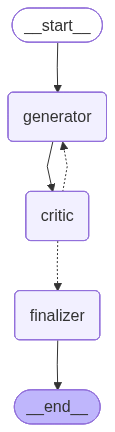

In [30]:
# Visualize
try:
    display(Image(reflection_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → generator → critic (loops back to generator) → finalizer → END")

**🎨 Notice:** critic can send back to generator for refinement!

### Test Reflection

In [27]:
result = reflection_agent.invoke({
    "task": "Explain what an agentic pattern is in 2-3 sentences",
    "draft": "",
    "critique": "",
    "iterations": 0
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT (after reflection):")
print(f"{'='*70}")
print(result["final_output"])
print(f"\nTotal iterations: {result['iterations']}")
print(f"{'='*70}\n")


✍️ Generating initial draft...
✓ Draft created

🔍 Critiquing draft...
Critique: The response provides a clear and concise definition of an agentic pattern, effectively capturing it


✍️ Refining (iteration 1)...
✓ Draft created

🔍 Critiquing draft...
Critique: The response provides a clear definition of an agentic pattern and includes a relevant example, whic

⚠️ Max iterations (2) reached


✅ Reflection complete!


📊 FINAL OUTPUT (after reflection):
An agentic pattern occurs when individuals take active control of their actions and decisions, showcasing their autonomy and self-efficacy. For instance, a person who sets and pursues personal goals, rather than simply accepting their situation, exemplifies this proactive approach to shaping their life.

Total iterations: 2



**🎯 Observe:** You can see the agent refining its own work!

---
## Section 9: Pattern Comparison

| Pattern | Best For | Pros | Cons | Helper Available? |
|---------|----------|------|------|------------------|
| **ReAct** | General tool usage | Simple, flexible | Can be inefficient | ✅ Yes |
| **Plan-Execute** | Complex multi-step tasks | Predictable, transparent | Less adaptive | ❌ No |
| **Reflection** | Quality-critical outputs | Self-improving | Higher cost | ❌ No |

### When to Use Each

**ReAct:**
- ✅ Chatbots with tools
- ✅ RAG systems (retrieve as needed)
- ✅ General Q&A with actions

**Plan-Execute:**
- ✅ Research tasks
- ✅ Multi-step workflows
- ✅ Tasks needing transparency

**Reflection:**
- ✅ Content writing
- ✅ Code generation
- ✅ Creative tasks
- ✅ Quality > speed scenarios

### Can You Combine Them?

Yes! Common combinations:
- **Plan-Execute + ReAct:** Each step uses ReAct for tools
- **Reflection + ReAct:** Reflect on tool usage decisions
- **Plan-Execute + Reflection:** Reflect on entire plan

Advanced agents often use multiple patterns!

---
## Section 10: Summary

### What You Learned

1. **ReAct Pattern**
   - Reason → Act → Observe cycle
   - Built manually and with helper
   - Most common agent pattern

2. **Plan-Execute Pattern**
   - Plan upfront, execute sequentially
   - Better for complex tasks
   - More predictable than ReAct

3. **Reflection Pattern**
   - Generate → Critique → Refine
   - Self-improving agents
   - Higher quality outputs

4. **Manual vs Helpers**
   - Helpers great for simple ReAct
   - Manual needed for custom patterns
   - Choose based on requirements

### Key Takeaways

- **No one-size-fits-all** - Choose pattern for your use case
- **Start simple** - ReAct is often enough
- **Iterate** - Begin with basic, add complexity as needed
- **Understand internals** - Build manually first, use helpers later

### What's Next?

**Notebook 5: Multi-Agent Systems**
- Multiple agents working together
- Supervisor, collaborative, and debate patterns
- Scaling from single to multi-agent

---
## 🎯 Practice Exercises

### Exercise 1: Adaptive Reflection with Quality Metrics

**Task:** Improve Reflection with numerical quality scoring.

**Requirements:**
1. Critic scores draft on multiple criteria (1-5 each):
   - Clarity
   - Completeness
   - Accuracy
2. Use Pydantic model for structured scoring
3. Only refine if any score < 4
4. Track score improvements across iterations
5. Stop when all scores ≥ 4 or max iterations

**Example:**
```
Iteration 1: Clarity=3, Completeness=4, Accuracy=5 → Refine
Iteration 2: Clarity=5, Completeness=4, Accuracy=5 → Approved!
```

**Deliverables:**
- Reflection agent with quality metrics
- Test with task requiring refinement
- Visualize score improvements

### Exercise 2: Plan-Execute + Reflection Hybrid

**Task:** Combine Plan-Execute and Reflection patterns to create a high-quality multi-step agent.

**Concept:** Use Plan-Execute to break down complex tasks, then use Reflection on the final output to ensure quality.

**Requirements:**
1. Create a hybrid state that includes:
   - Plan-Execute state (input, plan, current_step, results)
   - Reflection state (draft, critique, iterations)
2. Flow: Planner → Executor (loop) → Generator (uses results) → Critic → Refiner (if needed) → Finalizer
3. The Generator creates initial output from all executor results
4. The Critic evaluates the complete output (not individual steps)
5. Refine the final output based on critique (max 2 reflection iterations)
6. Track both execution progress AND reflection quality

**Architecture:**
```
START
  ↓
Planner (creates plan)
  ↓
Executor (executes each step)
  ↓ (loops until all steps done)
  ↓
Generator (synthesizes results into draft)
  ↓
Critic (evaluates quality)
  ↓
Should Refine?
  ↓              ↓
Refiner       Finalizer
  ↓              ↓
Critic         END
  (loops)
```

**Test scenario:**
```
Task: "Research the benefits of Python programming, create a summary, and make it beginner-friendly"

Expected flow:
1. PLAN: 
   - Step 1: Search for Python benefits
   - Step 2: Identify key benefits
   - Step 3: Create summary
2. EXECUTE: Complete all steps
3. GENERATE: Create initial summary from results
4. REFLECT: Critique summary for beginner-friendliness
5. REFINE: Simplify language and add examples
6. FINAL: High-quality, beginner-friendly summary
```

**Deliverables:**
1. Combined state definition (TypedDict)
2. All necessary nodes (planner, executor, generator, critic, refiner, finalizer)
3. Graph with proper edges and conditional routing
4. Test with the scenario above
5. Print output showing:
   - The plan
   - Each execution step
   - Initial draft
   - Critique
   - Refined version (if applicable)
   - Final output

---

## Reflection Questions

1. **Why is ReAct the most popular agent pattern?**

2. **When would Plan-Execute fail but ReAct succeed?**

3. **How does Reflection pattern differ from Self-RAG?**

4. **Why don't helpers exist for Plan-Execute or Reflection?**

5. **Could you build a "Plan-Execute-Reflect" hybrid? How?**

6. **What are the cost implications of each pattern?**

Think about these patterns as you build agents!

---

**🎉 Notebook 4 Complete!**

You now understand core agentic patterns. Next: Multi-Agent Systems! 🚀